<a href="https://colab.research.google.com/github/sysyJEON/class_ai4ml/blob/main/ml_guide/ch04_Classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4.9 분류 실습 - 캐글 산탄데르 고객 만족 예측

캐글의 산탄데르 고객 만족(Santander Customer Satisfcation) 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측
- 370개 피처
- 클래스 레이블 명은 TARGET
- 1이면 불만, 0이면 만족
- 모델 성능 평가는 ROC-AUC(ROC 곡선 영역)로 평가

### 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("/content/drive/MyDrive/데이터/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


클래스 값 칼럼 포함 피처 371개 존재

In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


- 111개 피처가 float, 260개 피처가 숫자 형, Null 값은 없음

전체 데이터에서 만족과 불만족 비율 살펴보기
- 레이블인 Target 속성의 값의 분포 알아봄

In [4]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


- 대부분 만족, 불만족 고객은 4%에 불과

In [5]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


- var3 칼럼 min 값이 -999999(NaN이나 특정 예외 값을 변환한 값일 것)
- `print(cust_df.var3.value_counts()[:10])`로 var3 조사해보면 -999999 값이 116개 있음
- -999999를 가장 값이 많은 2로 변환

In [6]:
cust_df['var3'].value_counts()

,count
var3,
2,74165
8,138
-999999,116
9,110
3,108
...,...
231,1
188,1
168,1


In [7]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트 분리

비대칭한 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


- 학습과 테스트 데이터 세트 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4%가 불만족 값(1)으로 만들어짐

In [9]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리.
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

XGBoost의 학습 모델 생성하고 예측 결과를 ROC AUC로 평가
- 사이킷런 래퍼 XGBClassifier 기반으로 학습 수행

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156, early_stopping_rounds=100, eval_metric='auc')

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85105	validation_1-auc:0.81965
[12]	validation_0-auc:0.85217	validation_1-auc:0.81999
[13]	validation_0-auc:0.85301	validation_1-auc:0.82049
[14]	validation_0-auc:0.85558	validation_1-auc:0.82210
[15]	validation_0-auc:0.85662	validation_1-auc:0.82288
[16]	validation_0-auc:0.85811	validation_1-auc:0.82380
[17]	validation_0-auc:0.85864	validation_1-auc:0.82365
[18]	validation_0-au

테스트 데이터 세트로 예측 시 ROC AUC는 약 0.8417

HyperOpt 이용해 베이지안 최적화 기반으로 XGBoost 하이퍼 파라미터 튜닝 수행

In [13]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색공간 설정

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

목적 함수 설정
- 3 Fold 교차 검증을 이용해 평균 ROC-AUC 값을 반환하되 -1 곱해주어 최대 ROC-AUC 값이 최소 반환값이 되게 함
- 교차 검증 시 XGBoost의 조기 중단과 검증 데이터 성능 평가 위해 KFold 클래스 이용하여 직접 학습과 검증 데이터 세트 추출하고 이를 교차 검증 횟수만큼 성능 평가 수행

In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import numpy as np

# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            early_stopping_rounds=30, eval_metric='auc'
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []

    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        xgb_clf.fit(X_tr, y_tr,
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

`fmin()` 함수 호출해 50회만큼 반복하면서 최적의 하이퍼 파라미터 도출
- 약 30분 소요...

In [19]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[66]	validation_0-auc:0.92541	validation_1-auc:0.83076
[67]	validation_0-auc:0.92558	validation_1-auc:0.83075
[68]	validation_0-auc:0.92561	validation_1-auc:0.83064
[69]	validation_0-auc:0.92588	validation_1-auc:0.83060
[70]	validation_0-auc:0.92633	validation_1-auc:0.83030
[71]	validation_0-auc:0.92674	validation_1-auc:0.83008
[72]	validation_0-auc:0.92674	validation_1-auc:0.83019
[73]	validation_0-auc:0.92697	validation_1-auc:0.83000
[0]	validation_0-auc:0.79699	validation_1-auc:0.75771
[1]	validation_0-auc:0.80823	validation_1-auc:0.75852
[2]	validation_0-auc:0.85488	validation_1-auc:0.80177
[3]	validation_0-auc:0.86613	validation_1-auc:0.81605
[4]	validation_0-auc:0.87207	validation_1-auc:0.81836
[5]	validation_0-auc:0.87502	validation_1-auc:0.82251
[6]	validation_0-auc:0.87455	validation_1-auc:0.82088
[7]	validation_0-auc:0.87866	validation_1-auc:0.82335
[8]	validation_0-auc:0.87925	validation_1-auc:0.82030
[9]	validation_0-auc:0.87939	validatio

도출된 최적 하이퍼 파라미터를 기반으로 XGBClassifier 재학습시키고 테스트 데이터 세트에서 ROC AUC 측정

In [22]:
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'], 5),
                        early_stopping_rounds=100, eval_metric="auc"
                       )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr,
            eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.75617	validation_1-auc:0.72424
[1]	validation_0-auc:0.76951	validation_1-auc:0.74072
[2]	validation_0-auc:0.82130	validation_1-auc:0.80125
[3]	validation_0-auc:0.83279	validation_1-auc:0.81455
[4]	validation_0-auc:0.83956	validation_1-auc:0.81850
[5]	validation_0-auc:0.84333	validation_1-auc:0.82213
[6]	validation_0-auc:0.84084	validation_1-auc:0.81983
[7]	validation_0-auc:0.84478	validation_1-auc:0.82208
[8]	validation_0-auc:0.84368	validation_1-auc:0.82108
[9]	validation_0-auc:0.83998	validation_1-auc:0.81681
[10]	validation_0-auc:0.84522	validation_1-auc:0.82318
[11]	validation_0-auc:0.84725	validation_1-auc:0.82612
[12]	validation_0-auc:0.84671	validation_1-auc:0.82558
[13]	validation_0-auc:0.84554	validation_1-auc:0.82439
[14]	validation_0-auc:0.84456	validation_1-auc:0.82284
[15]	validation_0-auc:0.84872	validation_1-auc:0.82748
[16]	validation_0-auc:0.85139	validation_1-auc:0.82836
[17]	validation_0-auc:0.85154	validation_1-auc:0.82826
[18]	validation_0-au

- 개선됨

튜닝된 모델에서 각 피처의 중요도 그래프

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

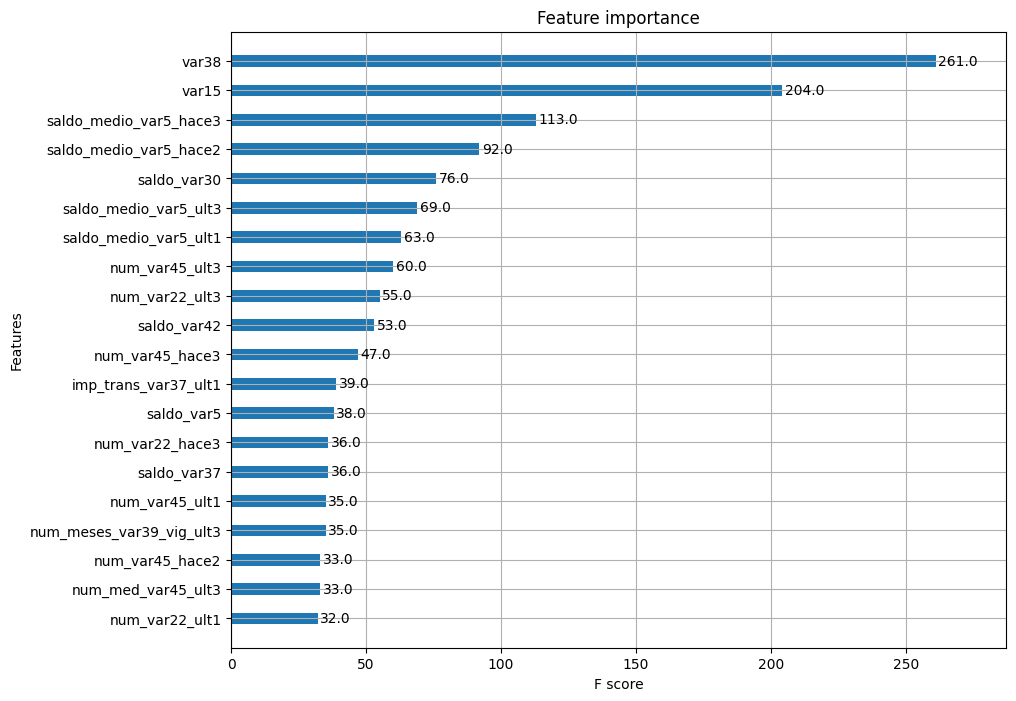

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

- XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15 순

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

LightGBM으로 학습 수행, ROC-AUC 측정

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

- XGBoost보다 학습 시간 조금 단축

HyperOpt 이용하여 하이퍼 파라미터 튜닝
- 튜닝 대상은 num_leaves, max_depth, min_child_samples, subsample, learning_rate
- 이를 위한 검색 공간 설정

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

목적 함수 생성

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']),
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []

    # 3개 k-fold방식 적용
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

`fmin()` 호출하여 최적 하이퍼 파라미터 도출

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

결과 하이퍼 파라미터 이용하여 LightGBM 학습 후 테스트 데이터 세트에서 ROC-AUC 평가

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']),
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5)
                          )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

## 4.10 분류 실습 - 캐글 신용카드 사기 검출

해당 데이터 세트인 Class 속성 매우 불균형한 분포
- Class는 0과 1로 분류
- 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터
- 1은 신용카드 사기 트랜잭션
- 전체 데이터의 약 0.172%만이 레이블 값 1, 즉 사기 트랜잭션

### 언더 샘플링과 오버 샘플링의 이해

지도학습에서 극도록 불균형한 레이블 값 분포로 인한 문제점 해결하기 위해 적절한 학습 데이터 확보 방안 필요
- 대표적으로 오버 샘플링(Oversampling)과 언더 샘플링(Undersampling) 방법
- 오버 샘플링 방식이 예측 성능상 조금 유리한 경우 많아 상대적으로 더 많이 사용됨

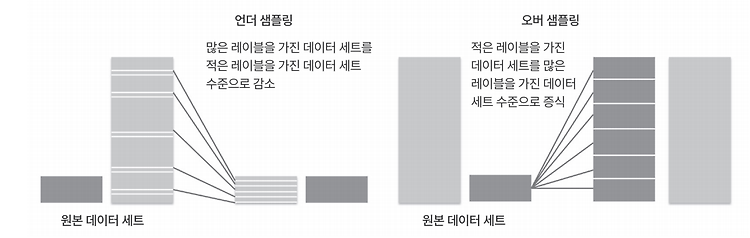

언더 샘플링
- 과도하게 정상 레이블로 학습/예측하는 부작용 개선
- 너무 많은 정상 레이블 데이터 감소시켜 정상 레이블 제대로된 학습 수행할 수 없는 문제 발생

오버 샘플링
- 동일한 데이터를 단순 증식하면 과저합(Overfitting) 되기 때문에 의미 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식함
- 대표적으로 SMOTE(Synthetic Minority Over-sampling Technique) 방법
  - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor) 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

### 데이터 일차 가공 및 모델 학습/예측/평가

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/데이터/creditcard.csv')
card_df.head(3)

불필요한 Time 피처 삭제

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트 반환

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target) # 테스트 데이터 세트 전체의 30%
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하ㅔ 분할됐는지 확인

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

로지스틱 회귀 이용해 신용 카드 사기 여부 예측

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

LightGBM 이용한 모델

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
# 데이터 세트가 극도로 불균형한 분포를 이루는 경우 boost_from_average=False로 설정
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 데이터 분포도 변환 후 모델 학습/예측/평가

왜곡된 분포도를 가지는 데이터를 재가공한 뒤 모델을 다시 테스트

먼저 중요 피처(Amount) 값의 분포 살펴보기
- 로지스틱 회귀는 선형 모델이라 중요 피처 값이 정규 분포 형태 유지하는 것을 선호
- Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션 결정에 매우 중요한 속성일 가능성 높음

In [ ]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

- 꼬리가 긴 형태의 분포 곡선

Amount를 표준 정규 분포 형태로 변환한 뒤 로지스틱 회귀의 예측 성능 측정

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

- 정규 분포 형태로 Amount 피처값 변환 후 테스트 데이터 세트에 적용 결과
- 로지스틱 회귀: 정밀도, 재현율 오히려 조금 저하
- LightGBM: 약간 정밀도와 재현율이 저하되었지만 큰 변경은 없음

로그변환 수행
- 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

로그 변환 후 로지스틱 회귀와 LightGBM 모델에 적용한 후 예측 성능 확인

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

- 로지스틱 회귀: 정밀도 향상, 재현율 저하
- LightGBM: 재현율 향상

### 이상치 데이터 제거 후 모델 학습/예측/평가

IQR(Inter Quantile Range) 방식으로 이상치 확인

어떤 피처의 이상치 데이터를 검출할 것인지 선택 필요
- 상관성이 높은 피처들 위주로 검출
- DataFrame의 `corr()` 이용해 각 피처별로 상관도 구한 뒤 시본의 heatmap으로 시각화

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')
# RdBu: 양의 상관관계가 높을수록 색이 진한 파란색에 가까움, 음의 상관관계 높을수록 진한 빨간색에 가까움

- 맨 아래 위한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17
- V14에 대해서만 이상치 찾아 제거

IQR 이용해 이상치 검출 함수 생성 후 검출된 이상치 제거

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

- 이상치 데이터 제거 후 로지스틱 회귀와 LightGBM 모두 예측 성능 크게 향상

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

반드시 학습 데이터 세트만 오버 샘플링 해야 함

In [ ]:
#conda install -c conda-forge imbalanced-learn

앞 예제에서 생성한 학습 피처/레이블 데이터를 SMOTE 객체의 `fit_resample()` 메서드를 이용해 증식한 뒤 데이터 증식 전과 비교

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

로지스틱 회귀 모델 학습한 뒤 성능 평가

In [ ]:
lr_clf = LogisticRegression()# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

- 재현율이 크게 증가하지만 정밀도가 급격하게 저하
- 오버 샘플링으로 인해 원본에 비해 너무 많은 Class=1 데이터 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 1로 적용해 정밀도가 급격하게 떨어짐

분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떤 문제 발생하고 있느니 시각적으로 확인

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [ ]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

- 임계값이 0.99 이하에서는 재현율 매우 좋고 정밀도 극단적으로 낮음
- 0.99 이상에서는 반대로 재현율 떨어지고 정밀도 높아짐
- 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능 얻을 수 없음
- 올바른 예측 모델 생성되지 못함

LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

- 재현율은 높아지나 정밀도는 낮아지는 것이 일반적
- 정밀도 지표보다 재현율 지표를 높이는 것이 머신러닝 모델의 주요한 목표인 경우 SMOTE 적용이 좋음

## 4.11 스태킹 앙상블

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [ ]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성.
lr_final = LogisticRegression(C=10)

In [ ]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정.
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

### CV 세트 기반의 스태킹

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))